In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
from seagul.rllib.register_envs import register_all_envs; register_all_envs() # can do this on import right?

In [16]:
home_path = '/home/sgillen/work/'
checkpoint_path = home_path + 'seagul/seagul/notebooks/sym_rl/data/walker_14/PPO/PPO_Walker2DBulletEnv-v0_0_sgd_minibatch_size=1024,train_batch_size=15360_2019-11-16_12-56-23tt56opnr/checkpoint_408/checkpoint-408'



In [40]:
df = pd.read_csv(csv_path)
df

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,timesteps_this_iter,done,timesteps_total,episodes_total,training_iteration,...,perf/ram_util_percent,info/learner/default_policy/cur_kl_coeff,info/learner/default_policy/cur_lr,info/learner/default_policy/total_loss,info/learner/default_policy/policy_loss,info/learner/default_policy/vf_loss,info/learner/default_policy/vf_explained_var,info/learner/default_policy/kl,info/learner/default_policy/entropy,info/learner/default_policy/entropy_coeff
0,-755.775926,-1747.622695,-1254.576620,200.0,20,4000,False,4000,20,1,...,42.050000,1.000000,0.0003,8.926149,0.000984,8.924356,0.760673,0.000811,1.419850,0.0
1,-749.313837,-1786.701400,-1259.958430,200.0,20,4000,False,8000,40,2,...,48.366667,0.500000,0.0003,2.202467,-0.004663,2.206253,0.948812,0.001755,1.409478,0.0
2,-749.313837,-1786.701400,-1293.679964,200.0,20,4000,False,12000,60,3,...,52.175000,0.250000,0.0003,2.543973,-0.006758,2.548661,0.966872,0.008279,1.397364,0.0
3,-749.313837,-1828.931273,-1304.985319,200.0,20,4000,False,16000,80,4,...,52.200000,0.250000,0.0003,2.815287,-0.006514,2.820080,0.975230,0.006885,1.396400,0.0
4,-737.932344,-1828.931273,-1300.078528,200.0,20,4000,False,20000,100,5,...,52.200000,0.250000,0.0003,4.849793,-0.013633,4.860568,0.975987,0.011432,1.397043,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.500561,-372.466515,-146.956299,200.0,20,4000,False,584000,2920,146,...,55.575000,0.632812,0.0003,0.010083,-0.010964,0.016094,0.999968,0.007827,0.704527,0.0
146,-0.500561,-372.466515,-148.492568,200.0,20,4000,False,588000,2940,147,...,55.500000,0.632812,0.0003,0.017517,-0.013270,0.024295,0.999957,0.010259,0.705537,0.0
147,-0.500561,-374.280452,-148.204078,200.0,20,4000,False,592000,2960,148,...,55.500000,0.632812,0.0003,0.011224,-0.016672,0.023202,0.999961,0.007417,0.705149,0.0
148,-0.500561,-396.677423,-155.644561,200.0,20,4000,False,596000,2980,149,...,55.500000,0.632812,0.0003,0.033253,-0.015540,0.041440,0.999938,0.011620,0.703499,0.0


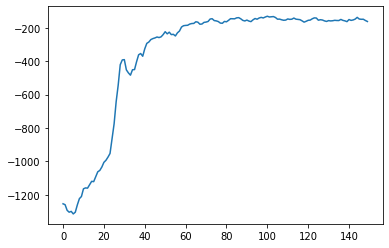

In [41]:
plt.plot(df['episode_reward_mean'])

In [22]:
ray.shutdown()
ray.init()

expr_path = "seagul/seagul/notebooks/sym_rl/data/walker_14/PPO/experiment_state-2019-11-16_12-56-23.json"

expr_data = json.load(open('/home/sgillen/work/' + expr_path))
config = expr_data['checkpoints'][-1]['config']
env_name = config['env']

#log_path = expr_data['checkpoints'][-1]['logdir']
#csv_path = log_path + '/path/progress.csv'

trainer = ppo.PPOTrainer(config)#, config['env_name'])
#trainer.restore(checkpoint_path)

2019-11-16 15:36:04,932	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-11-16 15:36:04,935	INFO resource_spec.py:205 -- Starting Ray with 4.74 GiB memory available for workers and up to 2.38 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-16 15:36:05,305	INFO trainer.py:345 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2019-11-16 15:36:07,322	INFO rollout_worker.py:768 -- Built policy map: {'default_policy': <ray.rllib.policy.tf_policy_template.PPOTFPolicy object at 0x7f45cecc4c50>}
2019-11-16 15:36:07,323	INFO rollout_worker.py:769 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f45cecc4358>}
2019-11-16 15:36:07,324	INFO rollout_worker.py:370 -- Built filter map: {'defa

-1.5063078718983578


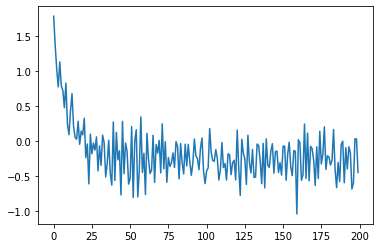

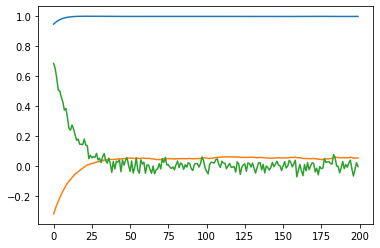

In [47]:
import gym
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

env = gym.make(env_name)
obs = env.reset()

action_hist = []
state_hist  = []
reward_hist = []

done = False
while not done:
    actions = trainer.compute_action(obs.flatten())
    obs, reward, done, _ = env.step(np.asarray(actions))
    env.render()
    action_hist.append(np.copy(np.clip(actions, -10, 10)))
    state_hist.append(np.copy(obs))
    reward_hist.append(np.copy(reward))
    if done:
        break


print(sum(reward_hist))
plt.plot(action_hist)
plt.figure()
plt.plot(state_hist)